# libraries to be imported

In [ ]:
import torch
import math
from torch import nn
import torch.nn.functional as F
from tensorflow.keras.datasets.imdb import load_data
from tensorflow.keras.datasets.imdb import get_word_index
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
from sklearn.model_selection import train_test_split

# **1-Data Loading and Preprocessing**

This section focuses on loading the IMDB dataset, padding the sequences, and splitting the data into training, validation, and test sets.

## **Dataset configuration**

In [ ]:
max_sequence_length = 300
max_features = 20000

## **Load the IMDB dataset**

In [ ]:
(x_train, y_train), (x_test, y_test) = load_data(
    num_words= max_features,
    skip_top=0,
    maxlen=max_sequence_length,
    start_char=1,
    oov_char=2,
    index_from=3,
)

17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
word_index = get_word_index()

1641221/1641221 ━━━━━━━━━━━━━━━━━━━━ 1s 1us/step


In [ ]:
inverted_word_index = {i + 3: word for word, i in word_index.items()}
max_vocab_size = max(inverted_word_index)
print(max_vocab_size)

88587


This is a function that turn the sequecen of numbers to words

In [ ]:
def decode_sequence(sequence,word_index):
    inverted_word_index = {i + 3: word for word, i in word_index.items()}
    inverted_word_index[1] = "[START]"
    inverted_word_index[2] = "[OOV]"

    decoded_sentence = " ".join(inverted_word_index.get(i, "[UNK]") for i in sequence)
    return decoded_sentence

Testing the Function

In [ ]:

word_index = word_index
sequence = [1, 6, 77, 4, 777]

decoded = decode_sequence(sequence, word_index)
print(decoded)

[START] a been the fantastic


In [ ]:
print("Training")
print(f"x_train shape = {x_train.shape}")
print(f"x_train shape = {y_train.shape}")
print("Testing")
print(f"x_test shape = {x_test.shape}")
print(f"y_test shape = {y_test.shape}")

Training
x_train shape = (19051,)
x_train shape = (19051,)
Testing
x_test shape = (19450,)
y_test shape = (19450,)


In [ ]:
x = np.concatenate([x_train, x_test], axis=0)
y = np.concatenate([y_train, y_test], axis=0)

In [ ]:
print(f"x shape = {x.shape}")
print(f"y shape = {y.shape}")

x shape = (38501,)
y shape = (38501,)


## **Pad the sequences**

This is done so that all the sentences are the same length.

In [ ]:
x_padded = pad_sequences(x, maxlen=max_sequence_length, padding='post', truncating='post')

## **Split into training, validation, and test sets**

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(
    x_padded, y, test_size=0.1, random_state=42
)

In [ ]:
x_val, x_test_fin, y_val, y_test_fin = train_test_split(
    x_test, y_test, test_size=0.9, random_state=42
)

## **Convert to tensors**

To be a suitable input.

In [ ]:
x_train_tensor = torch.tensor(x_train, dtype=torch.long)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

x_val_tensor = torch.tensor(x_val, dtype=torch.long)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

x_test_tensor = torch.tensor(x_test_fin, dtype=torch.long)
y_test_tensor = torch.tensor(y_test_fin, dtype=torch.float32)

In [ ]:
print(f"x_train_tensor shape: {x_train_tensor.shape}")
print(f"y_train_tensor shape: {y_train_tensor.shape}")
print(f"x_val_tensor shape: {x_val_tensor.shape}")
print(f"y_val_tensor shape: {y_val_tensor.shape}")
print(f"x_test_tensor shape: {x_test_tensor.shape}")
print(f"y_test_tensor shape: {y_test_tensor.shape}")

x_train_tensor shape: torch.Size([34650, 300])
y_train_tensor shape: torch.Size([34650])
x_val_tensor shape: torch.Size([385, 300])
y_val_tensor shape: torch.Size([385])
x_test_tensor shape: torch.Size([3466, 300])
y_test_tensor shape: torch.Size([3466])


# **1-Model Definition**

This section defines the necessary building blocks like positional encoding, feed-forward layers, and the transformer-based sentiment model.

In [ ]:
def get_mask(x, num_heads):
    # Create a mask where padding tokens (value 0) are marked as True
    # Shape: (batch_size, seq_length)
    pad_mask = (x == 0).float()

    # Expand to (batch_size, 1, 1, seq_length) to align with MultiheadAttention requirements
    attn_mask = pad_mask.unsqueeze(1).unsqueeze(2)  # Shape: (batch_size, 1, 1, seq_length)

    # Expand for multi-head attention and set invalid positions to -inf
    attn_mask = attn_mask.expand(-1, num_heads, x.size(1), -1)  # Shape: (batch_size, num_heads, seq_length, seq_length)

    attn_mask = attn_mask.reshape(-1, x.size(1), x.size(1)) * -1e9  # Shape: (batch_size * num_heads, seq_length, seq_length)

    return attn_mask

## **Positional Encoding**

In [ ]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, max_sequence_length):
        super().__init__()
        self.max_sequence_length = max_sequence_length
        self.d_model = d_model

    def forward(self):
        even_i = torch.arange(0, self.d_model, 2).float()
        denominator = torch.pow(10000, even_i/self.d_model)
        position = torch.arange(self.max_sequence_length).reshape(self.max_sequence_length, 1)
        even_PE = torch.sin(position / denominator)
        odd_PE = torch.cos(position / denominator)
        stacked = torch.stack([even_PE, odd_PE], dim=2)
        PE = torch.flatten(stacked, start_dim=1, end_dim=2)
        return PE

## **Positionwise Feed-Forward Layer**

In [ ]:
class PositionwiseFeedForward(nn.Module):

    def __init__(self, d_model, hidden, drop_prob=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.linear1 = nn.Linear(d_model, hidden)
        self.linear2 = nn.Linear(hidden, d_model)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=drop_prob)

    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.linear2(x)
        return x

## **Encoder Layer**

In [ ]:
class EncoderLayer(nn.Module):

    def __init__(self, d_model, ffn_hidden, num_heads, drop_prob):
        super(EncoderLayer, self).__init__()
        self.attention = torch.nn.MultiheadAttention(
            num_heads=num_heads,
            embed_dim=d_model,
            batch_first=True,
            dropout=drop_prob
        )
        self.norm1 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(p=drop_prob)
        self.ffn = PositionwiseFeedForward(d_model=d_model, hidden=ffn_hidden, drop_prob=drop_prob)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout2 = nn.Dropout(p=drop_prob)

    def forward(self, x, self_attention_mask = None):
        residual_x = x
        if self_attention_mask is not None:
            x = self.attention(query=x, key=x, value=x, attn_mask=self_attention_mask, need_weights=False)[0]
        else:
            x = self.attention(query=x, key=x, value=x, need_weights=False)[0]
        x = self.dropout1(x)
        x = self.norm1(x + residual_x)
        residual_x = x
        x = self.ffn(x)
        x = self.dropout2(x)
        x = self.norm2(x + residual_x)
        return x

## **Sentence Embedding**

In [ ]:
class SentenceEmbedding(nn.Module):
    def __init__(self, max_sequence_length, d_model,vocab_size,device="cpu"):
        super().__init__()
        self.vocab_size = vocab_size
        self.max_sequence_length = max_sequence_length
        self.embedding = nn.Embedding(self.vocab_size, d_model)
        self.position_encoder = PositionalEncoding(d_model, max_sequence_length)
        self.dropout = nn.Dropout(p=0.1)
        self.device = device

    def forward(self, x):
        x = self.embedding(x).to(self.device)
        pos = self.position_encoder().to(self.device)
        x = self.dropout(x + pos)
        return x

## **Sentiment Model**

In [ ]:
class SentimentModel(torch.nn.Module):
    def __init__(self, vocab_size, num_heads, d_model, ffn_hidden, drop_prob, encoder_blocks,max_sequence_length,device="cpu"):
        self.device = device
        super().__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        self.SentenceEmbedding = SentenceEmbedding(max_sequence_length = max_sequence_length, d_model = d_model,vocab_size = vocab_size,device=device ).to(device)
        self.Encoder_model = torch.nn.ModuleList([
            EncoderLayer(d_model, ffn_hidden, num_heads, drop_prob)
            for _ in range(encoder_blocks)
        ]).to(device)
        self.final_linear = torch.nn.Linear(in_features=d_model, out_features=1).to(device)

    def forward(self, x):
        x = x.to(self.device).detach()
        Encoder_mask = get_mask(x, num_heads=self.num_heads).to(self.device)
        attn_mask = Encoder_mask.to(self.device)
        inputs = self.SentenceEmbedding(x)
        hidden = inputs
        for block in self.Encoder_model:
            hidden = block(hidden, self_attention_mask=attn_mask)

        hidden = torch.mean(hidden, dim=1, keepdim=False)

        Encoder_outputs = torch.sigmoid(self.final_linear(hidden))

        return Encoder_outputs

# **3-Training and Validation**
This section handles the training loop and validation.

In [ ]:
device = "cuda"
d_model = 16
ffn_hidden = 2048
num_heads = 8
lr = 0.001
drop_prob = 0.3
encoder_blocks = 2

x_train_device = x_train_tensor.to(device)
y_train_device = torch.FloatTensor(y_train_tensor).unsqueeze(1).to(device)
x_val_device = x_val_tensor.to(device)
y_val_device = torch.FloatTensor(y_val_tensor).unsqueeze(1).to(device)
x_test_device = x_test_tensor.to(device)
y_test_device = torch.FloatTensor(y_test_tensor).unsqueeze(1).to(device)

## **Initialize model, criterion, and optimizer**

In [ ]:
model = SentimentModel(vocab_size= max_vocab_size,num_heads=num_heads,d_model=d_model,ffn_hidden=ffn_hidden,drop_prob=drop_prob,
                       encoder_blocks=encoder_blocks,
                       max_sequence_length=max_sequence_length,
                       device=device)

criterion = torch.nn.BCELoss().to(device)
opt = torch.optim.Adam(model.parameters(), lr=lr)

## **Create DataLoaders**

In [ ]:
from torch.utils.data import DataLoader, TensorDataset

# Create DataLoaders for batching
batch_size = 256
train_dataset = TensorDataset(x_train_device, y_train_device)
val_dataset = TensorDataset(x_val_device, y_val_device)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
from tqdm import tqdm

## **Training Loop**

In [ ]:
# Initialize lists to store metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

epochs = 20
best_val_loss = float('inf')
model_save_path = "sentiment_model_18.pth"

for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    train_correct = 0
    total_train_samples = 0

    for x_batch, y_batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} - Training"):
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        opt.zero_grad()
        loss.backward()
        opt.step()

        train_loss += loss.item() * x_batch.size(0)
        predictions = (outputs >= 0.5).float()
        train_correct += (predictions == y_batch).sum().item()
        total_train_samples += x_batch.size(0)

    train_loss /= total_train_samples
    train_accuracy = train_correct / total_train_samples
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    model.eval()
    val_loss = 0.0
    val_correct = 0
    total_val_samples = 0
    with torch.no_grad():
        for x_batch, y_batch in tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} - Validation"):
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)

            val_loss += loss.item() * x_batch.size(0)
            predictions = (outputs >= 0.5).float()
            val_correct += (predictions == y_batch).sum().item()
            total_val_samples += x_batch.size(0)

    val_loss /= total_val_samples
    val_accuracy = val_correct / total_val_samples
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), model_save_path)
        print(f"Model saved to {model_save_path} with Val Loss: {best_val_loss:.4f}")

print("Training complete!")


Epoch 1/20 - Validation: 100%|██████████| 2/2 [00:00<00:00, 15.08it/s]


Epoch 1/20
Train Loss: 0.6982, Train Accuracy: 0.5020
Val Loss: 0.6896, Val Accuracy: 0.5377
Model saved to sentiment_model_18.pth with Val Loss: 0.6896


Epoch 2/20 - Validation: 100%|██████████| 2/2 [00:00<00:00, 15.36it/s]


Epoch 2/20
Train Loss: 0.6751, Train Accuracy: 0.5554
Val Loss: 0.6164, Val Accuracy: 0.6701
Model saved to sentiment_model_18.pth with Val Loss: 0.6164


Epoch 3/20 - Validation: 100%|██████████| 2/2 [00:00<00:00, 15.17it/s]


Epoch 3/20
Train Loss: 0.5100, Train Accuracy: 0.7520
Val Loss: 0.4640, Val Accuracy: 0.8104
Model saved to sentiment_model_18.pth with Val Loss: 0.4640


Epoch 4/20 - Validation: 100%|██████████| 2/2 [00:00<00:00, 15.30it/s]


Epoch 4/20
Train Loss: 0.4064, Train Accuracy: 0.8176
Val Loss: 0.3598, Val Accuracy: 0.8519
Model saved to sentiment_model_18.pth with Val Loss: 0.3598


Epoch 5/20 - Validation: 100%|██████████| 2/2 [00:00<00:00, 14.68it/s]


Epoch 5/20
Train Loss: 0.3531, Train Accuracy: 0.8481
Val Loss: 0.3331, Val Accuracy: 0.8779
Model saved to sentiment_model_18.pth with Val Loss: 0.3331


Epoch 6/20 - Validation: 100%|██████████| 2/2 [00:00<00:00, 15.21it/s]


Epoch 6/20
Train Loss: 0.3232, Train Accuracy: 0.8623
Val Loss: 0.3219, Val Accuracy: 0.8857
Model saved to sentiment_model_18.pth with Val Loss: 0.3219


Epoch 7/20 - Validation: 100%|██████████| 2/2 [00:00<00:00, 15.10it/s]


Epoch 7/20
Train Loss: 0.2994, Train Accuracy: 0.8752
Val Loss: 0.2960, Val Accuracy: 0.8779
Model saved to sentiment_model_18.pth with Val Loss: 0.2960


Epoch 8/20 - Validation: 100%|██████████| 2/2 [00:00<00:00, 15.25it/s]


Epoch 8/20
Train Loss: 0.2847, Train Accuracy: 0.8815
Val Loss: 0.3009, Val Accuracy: 0.8805


Epoch 9/20 - Validation: 100%|██████████| 2/2 [00:00<00:00, 15.32it/s]


Epoch 9/20
Train Loss: 0.2684, Train Accuracy: 0.8890
Val Loss: 0.2988, Val Accuracy: 0.8831


Epoch 10/20 - Validation: 100%|██████████| 2/2 [00:00<00:00, 14.74it/s]


Epoch 10/20
Train Loss: 0.2544, Train Accuracy: 0.8971
Val Loss: 0.2853, Val Accuracy: 0.8987
Model saved to sentiment_model_18.pth with Val Loss: 0.2853


Epoch 11/20 - Validation: 100%|██████████| 2/2 [00:00<00:00, 14.91it/s]


Epoch 11/20
Train Loss: 0.2419, Train Accuracy: 0.9018
Val Loss: 0.3000, Val Accuracy: 0.8961


Epoch 12/20 - Validation: 100%|██████████| 2/2 [00:00<00:00, 15.34it/s]


Epoch 12/20
Train Loss: 0.2311, Train Accuracy: 0.9083
Val Loss: 0.2844, Val Accuracy: 0.9013
Model saved to sentiment_model_18.pth with Val Loss: 0.2844


Epoch 13/20 - Validation: 100%|██████████| 2/2 [00:00<00:00, 15.42it/s]


Epoch 13/20
Train Loss: 0.2235, Train Accuracy: 0.9105
Val Loss: 0.2954, Val Accuracy: 0.9013


Epoch 14/20 - Validation: 100%|██████████| 2/2 [00:00<00:00, 15.41it/s]


Epoch 14/20
Train Loss: 0.2154, Train Accuracy: 0.9154
Val Loss: 0.2921, Val Accuracy: 0.8987


Epoch 15/20 - Validation: 100%|██████████| 2/2 [00:00<00:00, 15.21it/s]


Epoch 15/20
Train Loss: 0.2079, Train Accuracy: 0.9186
Val Loss: 0.3007, Val Accuracy: 0.9039


Epoch 16/20 - Validation: 100%|██████████| 2/2 [00:00<00:00, 14.96it/s]


Epoch 16/20
Train Loss: 0.1989, Train Accuracy: 0.9226
Val Loss: 0.3037, Val Accuracy: 0.9013


Epoch 17/20 - Validation: 100%|██████████| 2/2 [00:00<00:00, 14.76it/s]


Epoch 17/20
Train Loss: 0.1898, Train Accuracy: 0.9274
Val Loss: 0.3080, Val Accuracy: 0.8961


Epoch 18/20 - Validation: 100%|██████████| 2/2 [00:00<00:00, 15.25it/s]


Epoch 18/20
Train Loss: 0.1841, Train Accuracy: 0.9298
Val Loss: 0.3067, Val Accuracy: 0.8987


Epoch 19/20 - Validation: 100%|██████████| 2/2 [00:00<00:00, 15.24it/s]


Epoch 19/20
Train Loss: 0.1787, Train Accuracy: 0.9322
Val Loss: 0.3065, Val Accuracy: 0.8987


Epoch 20/20 - Validation: 100%|██████████| 2/2 [00:00<00:00, 15.19it/s]

Epoch 20/20
Train Loss: 0.1749, Train Accuracy: 0.9324
Val Loss: 0.3075, Val Accuracy: 0.9013
Training complete!


Plot training and validation loss and plot training and validation accuracy.

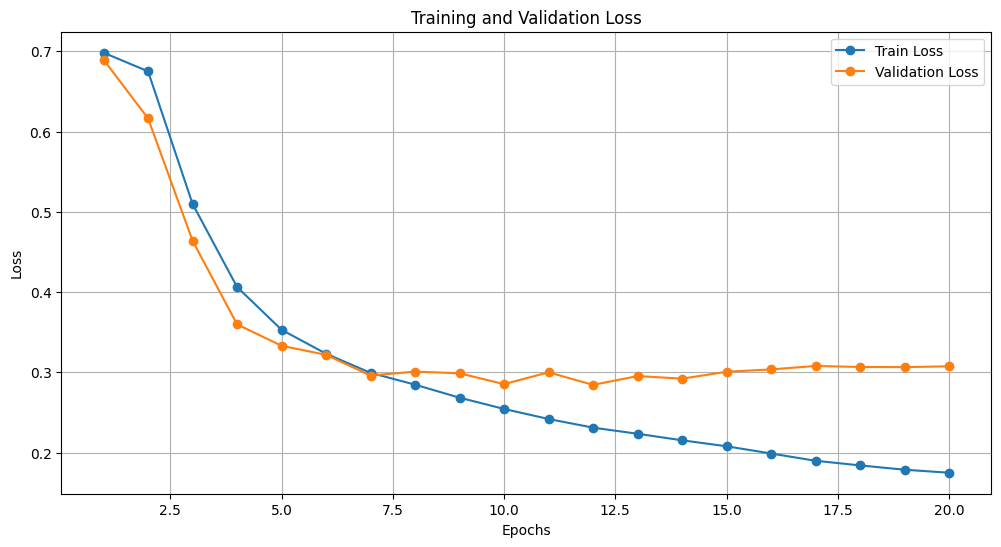

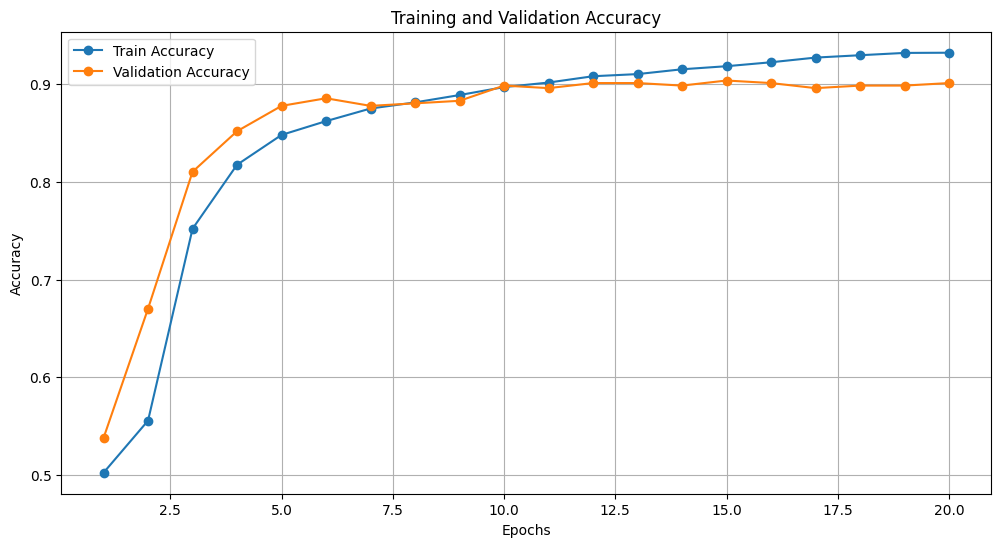

In [ ]:
import matplotlib.pyplot as plt
# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(range(1, epochs+1), train_losses, label='Train Loss', marker='o')
plt.plot(range(1, epochs+1), val_losses, label='Validation Loss', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(range(1, epochs+1), train_accuracies, label='Train Accuracy', marker='o')
plt.plot(range(1, epochs+1), val_accuracies, label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()


# **4-Evaluation**

This section handles evaluating the model's performance on the test set.

In [ ]:
model.eval()

test_loss = 0.0
test_correct = 0
total_test_samples = 0

all_predictions = []
all_labels = []

with torch.no_grad():
    for x_batch, y_batch in tqdm(DataLoader(TensorDataset(x_test_device, y_test_device), batch_size=256), desc="Testing"):

        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)


        test_loss += loss.item() * x_batch.size(0)
        predictions = (outputs >= 0.5).float()
        test_correct += (predictions == y_batch).sum().item()
        total_test_samples += x_batch.size(0)


        all_predictions.extend(predictions.cpu().numpy().flatten())
        all_labels.extend(y_batch.cpu().numpy().flatten())


test_loss /= total_test_samples
test_accuracy = test_correct / total_test_samples

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

Testing: 100%|██████████| 14/14 [00:01<00:00, 11.35it/s]

Test Loss: 0.3141
Test Accuracy: 0.8837


In [ ]:
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

## **Compute confusion matrix and F1 score**

In [ ]:
conf_matrix = confusion_matrix(all_labels, all_predictions)
f1 = f1_score(all_labels, all_predictions)
precision = precision_score(all_labels, all_predictions)
recall = recall_score(all_labels, all_predictions)

print("\nConfusion Matrix:")
print(conf_matrix)

print(f"\nF1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")


Confusion Matrix:
[[1482  228]
 [ 175 1581]]

F1 Score: 0.8870
Precision: 0.8740
Recall: 0.9003


This function is used to get one sentence then use the model to predect the label positive or negative.

In [ ]:
def one_review(model, x_test, x_test_sentence, y_test, criterion):
    model = model
    review = x_test_sentence
    label = y_test
    criterion = criterion
    input = x_test

    input = input.unsqueeze(0)  # Add a batch dimension

    model.eval()
    with torch.no_grad():
        outputs = model(input)

        outputs = outputs.squeeze(1)  # Remove the extra dimension

        loss = criterion(outputs, label)
        predictions = (outputs >= 0.5).float()

        if predictions == 1:
            predictions = "positive"
        else:
            predictions = "negative"

        if label == 1:
            label = "positive"
        else:
            label = "negative"

        print("Input sentence is:")
        print(review)
        print("true label is:")
        print(label)
        print("predicted label is:")
        print(predictions)

In [ ]:
sequences = x_test_fin[1]
y = y_test_fin[1]
decoded = decode_sequence(sequences, word_index)
print(decoded)
print(y)

[START] a show about an incredibly dumb man child and his [OOV] hot wife 99 of the plots revolves around doug doing something unbelievably stupid and then comes a variable a either he hides it from his wife or b tell his wife she him and then it's up to the father in law arthur the typecast character from seinfeld to [OOV] the situation br br and the writers dare to say it was influenced by the [OOV] an absolute classic and that the plots are drawn from real life situations unless you live in a cave you know that's not true br br anyway let's just put it this way if kevin james had been thin the show would have got canceled the pilot if you're 12 or you're fond of fat jokes be my guest watch this show or any of kevin james movies for that matter br br i've noticed some posters compare this travesty to much superior shows like friends seinfeld and everybody loves raymond i'm still wondering how could anyone do that [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] 

In [ ]:
one_review(model,x_test_device[1],decoded,y_test_device[1],criterion)

Input sentence is:
[START] a show about an incredibly dumb man child and his [OOV] hot wife 99 of the plots revolves around doug doing something unbelievably stupid and then comes a variable a either he hides it from his wife or b tell his wife she him and then it's up to the father in law arthur the typecast character from seinfeld to [OOV] the situation br br and the writers dare to say it was influenced by the [OOV] an absolute classic and that the plots are drawn from real life situations unless you live in a cave you know that's not true br br anyway let's just put it this way if kevin james had been thin the show would have got canceled the pilot if you're 12 or you're fond of fat jokes be my guest watch this show or any of kevin james movies for that matter br br i've noticed some posters compare this travesty to much superior shows like friends seinfeld and everybody loves raymond i'm still wondering how could anyone do that [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK]

In [ ]:
sequences = x_test_fin[2]
y = y_test_fin[2]
decoded = decode_sequence(sequences, word_index)
print(decoded)
print(y)

[START] this documentary was my first introduction to peak oil theory a fascinating concept that has a lot of frightening consequences if it turns out to be correct i had absolutely no idea that the effects of oil [OOV] would come so soon it literally took my breath away this movie will probably open your eyes as to how strongly the american way of life is dependent on the abundance of cheap oil a term used throughout the film a lot of the topics are plain common sense and they don't go into a huge amount of depth about any of them but you've probably never put all the pieces together like this movie does the interviews with the authors and energy experts are all very interesting i don't think this film is meant to scare people it's merely meant to inform people about what to expect in the years ahead and maybe to encourage you to think twice about to work and leaving your lights on all day long br br after watching this film i was no longer able to look at the cars and buses [OOV] by 

In [ ]:
one_review(model,x_test_device[2],decoded,y_test_device[2],criterion)

Input sentence is:
[START] this documentary was my first introduction to peak oil theory a fascinating concept that has a lot of frightening consequences if it turns out to be correct i had absolutely no idea that the effects of oil [OOV] would come so soon it literally took my breath away this movie will probably open your eyes as to how strongly the american way of life is dependent on the abundance of cheap oil a term used throughout the film a lot of the topics are plain common sense and they don't go into a huge amount of depth about any of them but you've probably never put all the pieces together like this movie does the interviews with the authors and energy experts are all very interesting i don't think this film is meant to scare people it's merely meant to inform people about what to expect in the years ahead and maybe to encourage you to think twice about to work and leaving your lights on all day long br br after watching this film i was no longer able to look at the cars 

In [ ]:
sequences = x_test_fin[100]
y = y_test_fin[100]
decoded = decode_sequence(sequences, word_index)
print(decoded)
print(y)

[START] first a word of caution the dvd box describes this film as a comedy i don't think that was the intention of anyone connected with the film other than some marketing morons while light and a little bit funny in places it is not a comedy and if you expect that you will be disappointed br br i had never even heard of this film and had absolutely no expectations one way or the other considering that the other two dvds i picked up were big disappointments i was so happy when i saw this film the acting writing and direction were excellent the story itself definitely interested me as you don't usually see films about the final month of france before the nazi [OOV] in 1940 it gave some insight into the parasites that gave up so quickly and agreed to their beloved country along the way there are plots involving a selfish and weak actress played very well by isabelle adjani who looks marvelous after all these years she kills an ex lover and then finds a poor sap to take the fall this sap

In [ ]:
one_review(model,x_test_device[100],decoded,y_test_device[100],criterion)

Input sentence is:
[START] first a word of caution the dvd box describes this film as a comedy i don't think that was the intention of anyone connected with the film other than some marketing morons while light and a little bit funny in places it is not a comedy and if you expect that you will be disappointed br br i had never even heard of this film and had absolutely no expectations one way or the other considering that the other two dvds i picked up were big disappointments i was so happy when i saw this film the acting writing and direction were excellent the story itself definitely interested me as you don't usually see films about the final month of france before the nazi [OOV] in 1940 it gave some insight into the parasites that gave up so quickly and agreed to their beloved country along the way there are plots involving a selfish and weak actress played very well by isabelle adjani who looks marvelous after all these years she kills an ex lover and then finds a poor sap to tak

In [ ]:
sequences = x_test_fin[1000]
y = y_test_fin[1000]
decoded = decode_sequence(sequences, word_index)
print(decoded)
print(y)

[START] the show is average it doesn't make me laugh particularly however i think courtney really brings it down she doesn't look natural she has these three ways to talk all robotic she talks quietly with no [OOV] she talks normally with no [OOV] or she does that thing where she starts talking normally and starts yelling gradually however her yelling is like let's pretend i'm yelling because i shouldn't be too loud on the set br br she is constantly aware of herself being this cute actress doing this funny thing it's annoying you can't really get her personality because she doesn't really produce emotion and doesn't get upset she has this husband who's doing all these stupid things and there is no reaction from her very dry and plain acting [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [U

In [ ]:
one_review(model,x_test_device[1000],decoded,y_test_device[1000],criterion)

Input sentence is:
[START] the show is average it doesn't make me laugh particularly however i think courtney really brings it down she doesn't look natural she has these three ways to talk all robotic she talks quietly with no [OOV] she talks normally with no [OOV] or she does that thing where she starts talking normally and starts yelling gradually however her yelling is like let's pretend i'm yelling because i shouldn't be too loud on the set br br she is constantly aware of herself being this cute actress doing this funny thing it's annoying you can't really get her personality because she doesn't really produce emotion and doesn't get upset she has this husband who's doing all these stupid things and there is no reaction from her very dry and plain acting [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [